In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def generate_initial_population(population_size, num_disks, num_towers=3):
    population = []
    for i in range(population_size):
        specimen = []
        min_length = 2 ** num_disks - 1
        # We allow for a slack of 50 movements after the optimum.
        max_length = min_length + 50
        specimen_size = random.randint(min_length, max_length)

        while len(specimen) < specimen_size:
            origin_tower = random.randint(1, num_towers)
            
            if len(specimen) == 0:
                origin_tower = 1
                
            destination_tower = random.randint(1, num_towers)
            # Don't perform bogus movements
            if origin_tower == destination_tower:
                continue
                
            element = (origin_tower, destination_tower)
            specimen.append(element)
            
        population.append(specimen)
    return population

In [3]:
def fitness(specimen, num_disks, print_state=lambda x: None):
    # We must play out the game to verify valid movements.
    state = [[i + 1 for i in range(num_disks)], [], []]
    print_state(state)
    
    fitness_value = 0
    for movement in specimen:
        origin_tower = movement[0] - 1
        destination_tower = movement[1] - 1
        
        # We ignore invalid movements and try to play out those that can be played.
        
        if len(state[origin_tower]) == 0:
            # Can't move from an empty tower, invalid movement.
            fitness_value = fitness_value - 5
            continue
        
        origin_peg = state[origin_tower][0]
        if len(state[destination_tower]) > 0 and state[destination_tower][0] < origin_peg:
            # Can't place a bigger peg on top of a smaller one, invalid movement.
            fitness_value = fitness_value - 5
            continue
            
        state[origin_tower].pop(0)
        state[destination_tower].insert(0, origin_peg)
        print_state(state)
        
        if len(state[1]) == num_disks or len(state[2]) == num_disks:
            # This is a successful run, grant a high amount of fitness
            fitness_value = fitness_value + 10000
            break
        
        fitness_value = fitness_value + 1
    
    # Penalize the specimen by the amount of pegs still remaining in the starting tower
    fitness_value = fitness_value - len(state[0]) * 10
    # Penalize the specimen by the number of movements it made
    fitness_value = fitness_value - len(specimen)
    
    fitness_value = fitness_value + max(len(state[1]), len(state[2])) * 5
    return fitness_value

In [4]:
def crossover(parents, population_len, num_disks):
    population = []
    for i in range(population_len):
        specimen = []
        while len(specimen) < 2 ** num_disks - 1:
            # Generate a new specimen by combining random parents
            parent_1, parent_2 = random.sample(parents, 2)

            parent_1_split = len(parent_1) // 2
            parent_2_split = len(parent_2) // 2
            
            part_1 = parent_1[:parent_1_split]
            part_2 = parent_2[parent_2_split:]
            
            random.shuffle(part_2)
            
            specimen = part_1
            specimen.extend(part_2)
        
        population.append(specimen)
    return population

In [5]:
def mutate(population, mutation_rate):
    for specimen in population:
        specimen_len = len(specimen)
        mutable_genes = random.randint(1, specimen_len)
        for gene in range(mutable_genes):
            if random.uniform(0, 1) >= mutation_rate:
                continue

            index = random.randint(1, specimen_len - 1)

            origin_tower = 0
            destination_tower = 0

            while origin_tower == destination_tower:
                origin_tower = random.randint(1, 3)
                destination_tower = random.randint(1, 3)

            element = (origin_tower, destination_tower)

            specimen[index] = element
    return population

In [6]:
num_disks = 5
population_size = 10000
crossover_parents_len = 1000
new_specimens_size = 600 # How many completely new specimens to introduce into the gene pool after each generation
num_generations = 400
mutation_rate = 0.35 + num_disks / 15
population = generate_initial_population(population_size, num_disks)
#population

In [7]:
len(population)

10000

In [8]:
generational_fitness = []

for generation in range(num_generations):
    population_fitness = [fitness(specimen, num_disks) for specimen in population]
    #print('Generation {} population fitness'.format(generation))
    #print(population_fitness)

    population_fitness, population = zip(*sorted(zip(population_fitness, population), reverse=True))

    best_index = np.argmax(population_fitness)
    best_specimen = population[best_index]
    best_fitness = fitness(best_specimen, num_disks)
    generational_fitness.append(best_fitness)
    print('Generation {} best index: {}. Fitness: {}'.format(generation, best_index, best_fitness))
    print('Generation {} best specimen'.format(generation))
    print(population[best_index])
    print('Generation {} best specimen final state'.format(generation))
    fitness(best_specimen, num_disks, lambda x: print(x))
    
    # Select only the best parents to breed the next generation
    parents = population[:crossover_parents_len]
    
    # Create the new population
    population = crossover(parents, population_size - new_specimens_size, num_disks)
    # Mutate the new population
    population = mutate(population, mutation_rate)
    
    # Introduce new, fresh specimens into the gene pool
    new_specimens = generate_initial_population(new_specimens_size, num_disks)
    population.extend(new_specimens)

Generation 0 best index: 0. Fitness: -61
Generation 0 best specimen
[(1, 3), (3, 2), (3, 1), (2, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (2, 1), (1, 2), (1, 2), (2, 1), (3, 1), (1, 3), (3, 2), (1, 3), (2, 3), (1, 3), (1, 3), (1, 2), (3, 1), (2, 1), (2, 1), (3, 1), (3, 2), (1, 3), (2, 3), (3, 1), (2, 3), (1, 3), (3, 2), (2, 1), (1, 2), (2, 3)]
Generation 0 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[2, 3, 4, 5], [1], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [1], [2, 3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[1, 5], [2, 4], [3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
Generation 1 best index: 0. Fitness: -43
G

Generation 9 best index: 0. Fitness: -25
Generation 9 best specimen
[(1, 2), (1, 3), (1, 2), (2, 3), (3, 2), (2, 1), (3, 2), (1, 2), (1, 3), (2, 1), (2, 3), (1, 2), (3, 2), (2, 3), (2, 3), (1, 2), (2, 1), (3, 2), (2, 3), (1, 2), (1, 2), (3, 1), (1, 3), (3, 2), (2, 1), (3, 2), (2, 3), (1, 3), (3, 2), (2, 3), (3, 2), (2, 3), (2, 3)]
Generation 9 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [1], []]
[[3, 4, 5], [1], [2]]
[[3, 4, 5], [], [1, 2]]
[[3, 4, 5], [1], [2]]
[[1, 3, 4, 5], [], [2]]
[[1, 3, 4, 5], [2], []]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[4, 5], [], [1, 2, 3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4]

Generation 17 best index: 0. Fitness: -31
Generation 17 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 2), (2, 1), (1, 2), (3, 2), (2, 3), (3, 1), (2, 1), (1, 3), (3, 1), (3, 2), (2, 3), (3, 2), (3, 1), (1, 2), (1, 3), (2, 1), (1, 3), (2, 3), (3, 1), (1, 2), (2, 1), (2, 3), (1, 3), (2, 1), (1, 2), (2, 1), (1, 2)]
Generation 17 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [1], [2, 3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[1, 4, 5], [], [2, 3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [2], [1, 3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5

Generation 25 best index: 0. Fitness: -13
Generation 25 best specimen
[(1, 3), (1, 2), (2, 1), (1, 2), (3, 1), (2, 3), (1, 3), (1, 2), (3, 1), (3, 2), (2, 3), (3, 2), (3, 1), (1, 2), (2, 3), (3, 1), (1, 2), (2, 3), (1, 2), (3, 1), (1, 3), (3, 2), (2, 3), (3, 2), (1, 3), (3, 1), (1, 3), (2, 1), (1, 3), (2, 1), (1, 2), (3, 2), (1, 3)]
Generation 25 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[1, 3, 4, 5], [2], []]
[[1, 3, 4, 5], [], [2]]
[[3, 4, 5], [], [1, 2]]
[[4, 5], [3], [1, 2]]
[[1, 4, 5], [3], [2]]
[[1, 4, 5], [2, 3], []]
[[1, 4, 5], [3], [2]]
[[1, 4, 5], [2, 3], []]
[[4, 5], [1, 2, 3], []]
[[4, 5], [2, 3], [1]]
[[1, 4, 5], [2, 3], []]
[[4, 5], [1, 2, 3], []]
[[4, 5], [2, 3], [1]]
[[1, 4, 5], [2, 3], []]
[[4, 5], [2, 3], [1]]
[[4, 5], [1, 2, 3], []]
[[4, 5], [2, 3], [1]]
[[4, 5], [1, 2, 3], []]
[[5], [1, 2, 3], [4]]
[[4, 5], [1, 2, 3], []]
[[5], [1, 2, 3], [4]]
[[1, 5], [2, 3], [4]]

Generation 33 best index: 0. Fitness: -22
Generation 33 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (1, 2), (2, 1), (3, 2), (3, 2), (2, 3), (1, 3), (3, 1), (1, 3), (1, 2), (3, 2), (3, 1), (2, 3), (3, 1), (1, 3), (1, 3), (1, 3), (3, 2), (2, 1), (1, 2), (2, 1), (2, 3), (3, 2), (1, 3), (3, 1), (1, 3), (1, 2), (1, 3), (3, 2), (1, 3)]
Generation 33 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
Generat

Generation 41 best index: 0. Fitness: -13
Generation 41 best specimen
[(1, 3), (1, 2), (3, 1), (1, 3), (3, 1), (2, 3), (1, 3), (1, 2), (3, 1), (3, 2), (1, 2), (1, 3), (2, 1), (2, 1), (1, 2), (2, 3), (3, 2), (2, 3), (2, 1), (3, 2), (2, 1), (2, 3), (3, 2), (2, 3), (1, 2), (1, 3), (1, 2), (1, 2), (2, 3), (3, 1), (1, 2), (2, 3), (3, 2)]
Generation 41 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[1, 3, 4, 5], [2], []]
[[3, 4, 5], [2], [1]]
[[1, 3, 4, 5], [2], []]
[[1, 3, 4, 5], [], [2]]
[[3, 4, 5], [], [1, 2]]
[[4, 5], [3], [1, 2]]
[[1, 4, 5], [3], [2]]
[[1, 4, 5], [2, 3], []]
[[4, 5], [1, 2, 3], []]
[[5], [1, 2, 3], [4]]
[[1, 5], [2, 3], [4]]
[[5], [1, 2, 3], [4]]
[[5], [2, 3], [1, 4]]
[[5], [1, 2, 3], [4]]
[[5], [2, 3], [1, 4]]
[[2, 5], [3], [1, 4]]
[[2, 5], [1, 3], [4]]
[[1, 2, 5], [3], [4]]
[[1, 2, 5], [], [3, 4]]
[[1, 2, 5], [3], [4]]
[[1, 2, 5], [], [3, 4]]
[[2, 5], [1], [3, 4]]
[[5], [1], [2, 3, 4]]
[[5], [], [1, 2, 3, 4]]
[[1, 5]

Generation 49 best index: 0. Fitness: -20
Generation 49 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 2), (2, 3), (3, 2), (2, 3), (1, 2), (3, 2), (2, 3), (3, 2), (2, 1), (1, 3), (3, 1), (1, 3), (1, 3), (2, 1), (1, 3), (1, 2), (3, 2), (3, 2), (3, 1), (2, 1), (3, 2), (1, 3), (2, 1), (1, 2), (3, 1), (1, 2), (3, 2)]
Generation 49 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[1, 5], [2, 

Generation 57 best index: 0. Fitness: -19
Generation 57 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (3, 2), (2, 3), (1, 2), (2, 3), (1, 2), (3, 2), (2, 3), (3, 2), (2, 1), (1, 2), (2, 3), (1, 2), (3, 2), (3, 1), (3, 2), (2, 3), (3, 2), (1, 3), (3, 2), (3, 1), (1, 3), (1, 2), (3, 1), (2, 3), (1, 2), (3, 1), (1, 2)]
Generation 57 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1,

Generation 65 best index: 0. Fitness: -22
Generation 65 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (3, 2), (2, 1), (2, 3), (1, 2), (2, 3), (1, 2), (1, 2), (2, 1), (1, 3), (1, 2), (3, 1), (3, 2), (1, 2), (3, 2), (2, 1), (1, 3), (3, 2), (2, 3), (2, 1), (3, 1), (2, 3), (3, 2), (3, 2), (1, 3), (1, 2), (3, 1), (1, 2), (1, 3)]
Generation 65 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[5], [1, 2, 4], [3]]
[[1, 5], [2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[5], [1, 2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[1, 5], [2, 3, 4], []]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
Generatio

Generation 73 best index: 0. Fitness: -25
Generation 73 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (2, 1), (2, 1), (1, 3), (3, 2), (2, 1), (3, 2), (1, 2), (1, 3), (2, 3), (3, 1), (1, 3), (3, 2), (3, 2), (1, 2), (1, 3), (3, 1), (2, 3), (3, 2), (1, 3), (2, 1), (1, 2), (2, 1), (1, 2)]
Generation 73 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[5], [1, 2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[1, 5], [2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[5], [1, 2, 4], [3]]
[[3, 5], [1, 2, 4], []]
[[3, 5], [2, 4], [1]]
[[3, 5], [1, 2, 4], []]
[[5], [1, 2, 4], [3]]
[[1, 5], [2, 4], [3]]
[[5], [1, 2, 4], [3]]
[[1, 5], [2, 4], [3]]
[[5], [1, 2, 4], [3]]
G

Generation 81 best index: 0. Fitness: -25
Generation 81 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (2, 1), (3, 2), (2, 3), (1, 3), (3, 2), (2, 1), (1, 2), (1, 2), (3, 1), (2, 3), (3, 1), (1, 2), (2, 3), (3, 2), (1, 2), (2, 1), (1, 3), (3, 1), (1, 2), (2, 1), (3, 1), (3, 2), (1, 3), (2, 3), (1, 2), (3, 2), (1, 3)]
Generation 81 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[4, 5], [1], [2, 3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [1], [2, 3]]
[[2, 4, 5], [1], [3]]
[[2, 4, 5], [], [1, 3]]
[[1, 2, 4, 5], [], [3]]
[[2, 4, 5], [1], [3]]
[[2, 4, 5], [], [1, 3]]
[[2, 4, 5], [1], [3]]
[[1, 2, 4, 5], [], [3]]
[[2, 4, 5], [], [1, 3]]
[[1, 2, 4, 5], [], [3]]
[[2, 4, 5], [1], [3]]
[[1, 2, 4, 5], [], [3]]
[[1, 2, 4, 5], [3], []]
[[2, 4, 5], [3], [1]]
[[4, 5], [2, 3], [1]]

Generation 89 best index: 0. Fitness: -13
Generation 89 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (2, 1), (1, 2), (3, 1), (2, 3), (3, 2), (1, 2), (2, 1), (1, 2), (2, 1), (2, 3), (3, 2), (2, 3), (1, 3), (2, 1), (1, 2), (3, 1), (1, 3), (3, 2), (3, 1), (2, 3), (1, 2), (3, 2), (2, 1), (3, 1), (1, 2)]
Generation 89 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[5], [1, 2, 4], [3]]
[[1, 5], [2, 4], [3]]
[[5], [1, 2, 4], [3]]
[[1, 5], [2, 4], [3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1, 3]]
[[5], [1, 2, 4], [3]]
[[1

Generation 97 best index: 0. Fitness: -19
Generation 97 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (2, 1), (3, 1), (1, 3), (2, 1), (3, 1), (1, 3), (1, 2), (3, 1), (3, 2), (1, 2), (3, 2), (1, 3), (3, 1), (2, 3), (3, 2), (1, 3), (2, 1), (2, 3), (2, 3), (1, 3), (3, 1), (1, 2), (2, 3)]
Generation 97 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[4, 5], [], [1, 2, 3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[5], [1, 2, 4], [3]]
[[3, 5], [1, 2, 4], []]
[[3, 5], [2, 4], [1]]
[[3, 5], [1, 2, 4], []]
[[5], [1, 2, 4], [3]]
[[1, 5], [2, 4], [3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2,

Generation 105 best index: 0. Fitness: -10
Generation 105 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 2), (1, 2), (2, 3), (1, 2), (3, 2), (3, 1), (2, 1), (2, 1), (3, 2), (1, 3), (3, 2), (2, 3), (3, 2), (2, 3), (1, 2), (3, 1), (3, 1), (2, 3), (3, 2), (2, 3), (3, 2), (3, 2), (3, 1), (1, 3), (3, 2), (1, 3)]
Generation 105 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[1, 5], [2, 3, 4], []]
[[1, 5], [3, 4], [2]]
[[1, 5], [2, 3, 4], []]
[[1, 5], [3, 4], [2]]
[[1, 5], [2, 3, 4], []]
[[5], [2, 3, 4], [1]]
[[5], [1, 2, 3, 4], []]
[[], [1, 2

Generation 114 best index: 0. Fitness: -13
Generation 114 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 3), (3, 1), (2, 3), (1, 3), (1, 2), (3, 2), (3, 1), (1, 2), (2, 1), (2, 3), (3, 2), (2, 3), (3, 2), (3, 2), (1, 2), (2, 1), (1, 2), (2, 3), (1, 2), (3, 2), (2, 1), (1, 2), (1, 3), (2, 3), (2, 1), (3, 1), (2, 3), (1, 3)]
Generation 114 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[4, 5], [2], [1, 3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [1, 3, 4], []]
[[1, 2, 5], [3, 4], []]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[5], [1, 2, 3, 4], []]
[[1, 5], [2, 3, 4], []]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
[[], [2, 3, 4], [1, 5]]
[[2], [3, 4], [1, 5]]
[[1,

Generation 122 best index: 0. Fitness: -4
Generation 122 best specimen
[(1, 3), (1, 2), (3, 2), (2, 1), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (2, 1), (2, 1), (3, 2), (3, 1), (1, 2), (1, 3), (3, 1), (1, 3), (2, 3), (3, 1), (1, 2), (2, 3), (2, 1), (3, 1), (2, 3), (1, 3), (3, 2), (1, 2), (2, 3), (3, 2), (1, 3), (2, 3), (1, 2)]
Generation 122 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[1, 3, 4, 5], [2], []]
[[1, 3, 4, 5], [], [2]]
[[3, 4, 5], [], [1, 2]]
[[4, 5], [3], [1, 2]]
[[4, 5], [1, 3], [2]]
[[1, 4, 5], [3], [2]]
[[1, 4, 5], [2, 3], []]
[[4, 5], [1, 2, 3], []]
[[5], [1, 2, 3], [4]]
[[4, 5], [1, 2, 3], []]
[[5], [1, 2, 3], [4]]
[[5], [2, 3], [1, 4]]
[[1, 5], [2, 3], [4]]
[[5], [1, 2, 3], [4]]
[[5], [2, 3], [1, 4]]
[[2, 5], [3], [1, 4]]
[[1, 2, 5], [3], [4]]
[[1, 2, 5], [], [3, 4]]
[[2, 5], [], [1, 3, 4]]
[[2, 5], [1], [3, 4]]
[[2, 5], [], [1, 3, 4]]
[[2, 5], [1], [3, 4]]
[[5], [1], [2, 3, 4]]
[[5], [], [

Generation 130 best index: 0. Fitness: -19
Generation 130 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (3, 1), (2, 3), (2, 1), (1, 2), (2, 1), (1, 3), (1, 2), (3, 1), (1, 2), (2, 1), (2, 1), (1, 3), (3, 2), (1, 2), (2, 1), (3, 2), (1, 2), (2, 1), (2, 3), (1, 3), (1, 2), (3, 1), (3, 2), (1, 2), (2, 3), (3, 1), (1, 2), (1, 3)]
Generation 130 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[3, 4, 5], [1, 2], []]
[[3, 4, 5], [2], [1]]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[1, 3, 4, 5], [2], []]
[[3, 4, 5], [1, 2], []]
[[1, 3, 4, 5], [2], []]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[1, 3, 4, 5], [2], []]
[[3, 4, 5], [1, 2], []]
[[1, 3, 4, 5], [2], []]
[[1, 3, 4, 5], [], [2]]
[[3, 4, 5], [], [1, 2]]
[[4, 5], [3], [1, 2]]
[[1, 4, 5], [3], [2]]
[[1, 4, 5], [2, 3], []]
[[4, 5], [1, 2, 3], []]
[[4, 5], [2, 3], [1]]
[[1, 4, 5], [2, 3], []

Generation 138 best index: 0. Fitness: -19
Generation 138 best specimen
[(1, 3), (1, 2), (3, 2), (3, 1), (2, 1), (2, 3), (1, 3), (1, 2), (2, 3), (3, 2), (2, 1), (1, 3), (3, 1), (1, 3), (3, 1), (1, 3), (3, 1), (1, 2), (2, 3), (2, 3), (3, 1), (3, 2), (2, 3), (3, 2), (1, 2), (1, 3), (3, 1), (2, 3), (3, 1), (2, 1), (1, 2), (1, 3)]
Generation 138 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[1, 3, 4, 5], [2], []]
[[1, 3, 4, 5], [], [2]]
[[3, 4, 5], [], [1, 2]]
[[4, 5], [3], [1, 2]]
[[4, 5], [1, 3], [2]]
[[1, 4, 5], [3], [2]]
[[4, 5], [3], [1, 2]]
[[1, 4, 5], [3], [2]]
[[4, 5], [3], [1, 2]]
[[1, 4, 5], [3], [2]]
[[4, 5], [3], [1, 2]]
[[1, 4, 5], [3], [2]]
[[4, 5], [1, 3], [2]]
[[4, 5], [3], [1, 2]]
[[1, 4, 5], [3], [2]]
[[1, 4, 5], [2, 3], []]
[[1, 4, 5], [3], [2]]
[[1, 4, 5], [2, 3], []]
[[4, 5], [1, 2, 3], []]
[[5], [1, 2, 3], [4]]
[[4, 5], [1, 2, 3], []]
[[4, 5], [2, 3], [1]]
[[1, 4, 5], [2, 3], []]
[[4, 5], [1,

Generation 146 best index: 0. Fitness: -16
Generation 146 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 1), (1, 3), (3, 2), (3, 1), (2, 1), (1, 2), (2, 1), (2, 3), (3, 2), (3, 2), (2, 1), (1, 2), (2, 3), (3, 2), (2, 3), (1, 2), (3, 1), (3, 1), (1, 2), (2, 3), (1, 3), (3, 2), (1, 3), (3, 2)]
Generation 146 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[1, 5], [2, 3, 4], []]
[[5], [1, 2, 3, 4], []]
[[5], [2, 3, 4], [1]]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
Generation

Generation 154 best index: 0. Fitness: -19
Generation 154 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (2, 1), (1, 3), (3, 2), (2, 1), (1, 2), (1, 2), (2, 3), (3, 2), (3, 1), (1, 2), (2, 1), (1, 3), (3, 2), (3, 2), (1, 2), (1, 3), (2, 3), (3, 1), (3, 2), (1, 3), (3, 1), (2, 3), (1, 3)]
Generation 154 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[1, 5], [2, 4], [3]]
[[1, 5], [4], [2, 3]]
[[

Generation 162 best index: 0. Fitness: -4
Generation 162 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (3, 1), (2, 1), (1, 3), (1, 2), (2, 1), (3, 2), (2, 3), (3, 1), (3, 2), (1, 2), (3, 1), (3, 1), (2, 3), (1, 2), (3, 1), (3, 1), (1, 2), (1, 2), (1, 3), (2, 1), (1, 2), (2, 1), (1, 2)]
Generation 162 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1, 3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[1, 5], [2, 3, 4], []]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
[[1], [2, 3, 4], [5]]
[[], [1, 2, 3, 4], [5]]
[[1], [2, 3, 

Generation 170 best index: 0. Fitness: -13
Generation 170 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (3, 2), (3, 1), (2, 3), (3, 2), (2, 3), (1, 2), (2, 1), (1, 2), (2, 1), (1, 2), (2, 1), (2, 3), (3, 1), (1, 3), (3, 2), (1, 3), (2, 1), (3, 2), (2, 3), (1, 3), (3, 1), (1, 3), (1, 2), (2, 3), (1, 2)]
Generation 170 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[4, 5], [1], [2, 3]]
[[2, 4, 5], [1], [3]]
[[2, 4, 5], [], [1, 3]]
[[2, 4, 5], [1], [3]]
[[2, 4, 5], [], [1, 3]]
[[4, 5], [2], [1, 3]]
[[2, 4, 5], [], [1, 3]]
[[4, 5], [2], [1, 3]]
[[2, 4, 5], [], [1, 3]]
[[4, 5], [2], [1, 3]]
[[2, 4, 5], [], [1, 3]]
[[1, 2, 4, 5], [], [3]]
[[2, 4, 5], [], [1, 3]]
[[2, 4, 5], [1], [3]]
[[4, 5], [1], [2, 3]]
[[1, 4, 5], [], [2, 3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[1,

Generation 178 best index: 0. Fitness: -22
Generation 178 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (2, 1), (1, 2), (3, 2), (3, 1), (2, 3), (1, 2), (2, 1), (3, 1), (3, 1), (2, 1), (2, 1), (3, 2), (2, 3), (3, 2), (1, 2), (1, 3), (1, 3), (3, 2), (2, 1), (3, 2), (1, 2), (1, 2), (1, 3), (3, 1), (1, 3)]
Generation 178 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1, 3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [1, 3, 4], []]
[[5], [1, 3, 4], [2]]
[[1, 5], [3, 4], [2]]
[[1, 5], [2, 3, 4], []]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
Generation 179 best index: 0. 

Generation 187 best index: 0. Fitness: -8
Generation 187 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 1), (3, 2), (1, 3), (3, 2), (2, 3), (2, 1), (3, 1), (3, 2), (1, 2), (2, 3), (3, 1), (1, 2), (2, 3), (3, 2), (1, 3), (2, 3), (1, 2), (3, 2), (2, 1), (2, 1), (3, 2), (1, 3), (2, 3), (3, 2)]
Generation 187 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[5], [1, 2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[2, 5], [1, 3, 4], []]
[[5], [1, 3, 4], [2]]
[[5], [3, 4], [1, 2]]
[[5], [1, 3, 4], [2]]
[[1, 5], [3, 4], [2]]
[[1, 5], [2, 3,

Generation 195 best index: 0. Fitness: -19
Generation 195 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 3), (2, 1), (3, 2), (1, 3), (2, 1), (3, 2), (1, 2), (2, 3), (1, 2), (3, 1), (2, 3), (1, 3), (1, 2), (3, 1), (3, 2), (1, 3), (2, 1), (1, 3), (1, 3), (3, 2), (2, 3), (1, 2), (3, 1), (1, 3), (3, 2), (3, 2), (2, 3), (3, 2)]
Generation 195 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[4, 5], [2], [1, 3]]
[[2, 4, 5], [], [1, 3]]
[[2, 4, 5], [1], [3]]
[[4, 5], [1], [2, 3]]
[[1, 4, 5], [], [2, 3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [1, 2], [3]]
[[4, 5], [2], [1, 3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1, 3]]
[[1, 5], [2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[5], [1, 2, 4], [3]]
[[5], [2, 4], [1, 3]

Generation 203 best index: 0. Fitness: -19
Generation 203 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (3, 1), (2, 1), (1, 3), (2, 1), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 2), (3, 1), (2, 3), (3, 2), (2, 3), (1, 2), (2, 1), (3, 2), (1, 3), (3, 2), (2, 3), (1, 2), (2, 1), (1, 3), (3, 1), (1, 3), (2, 3), (1, 2), (2, 3)]
Generation 203 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[3, 4, 5], [1, 2], []]
[[1, 3, 4, 5], [2], []]
[[3, 4, 5], [2], [1]]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [1], [2, 3]]
[[2, 4, 5], [1], [3]]
[[2, 4, 5], [], [1, 3]]
[[2, 4, 5], [1], [3]]
[[2, 4, 5], [], [1, 3]]
[[4, 5], [2], [1, 3]]
[[2, 4, 5], [], [1, 3]]
[[2, 4, 5], [1], [3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[4, 5], [], [1, 2, 3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5

Generation 212 best index: 0. Fitness: -10
Generation 212 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (3, 2), (2, 1), (1, 2), (3, 1), (2, 3), (3, 1), (1, 2), (2, 3), (3, 1), (3, 2), (1, 3), (2, 3), (1, 3), (3, 1), (1, 2), (3, 2), (2, 3), (1, 2), (2, 1), (1, 2), (3, 2), (1, 3), (1, 2)]
Generation 212 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4

Generation 220 best index: 0. Fitness: -19
Generation 220 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (3, 2), (1, 2), (2, 1), (1, 3), (2, 1), (1, 2), (2, 1), (1, 2), (2, 1), (1, 2), (1, 3), (3, 2), (3, 1), (1, 3), (1, 3), (2, 1), (2, 1), (2, 3), (3, 2), (1, 2), (2, 3), (3, 1), (2, 3), (1, 3), (3, 2), (2, 3), (1, 2)]
Generation 220 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [2], [1, 3]]
[[2, 4, 5], [], [1, 3]]
[[4, 5], [2], [1, 3]]
[[2, 4, 5], [], [1, 3]]
[[4, 5], [2], [1, 3]]
[[2, 4, 5], [], [1, 3]]
[[4, 5], [2], [1, 3]]
[[4, 5], [1, 2], [3]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [1, 2], [3]]
[[4, 5], [2], [1, 3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [

Generation 228 best index: 0. Fitness: -19
Generation 228 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 1), (1, 3), (3, 1), (1, 2), (2, 3), (3, 2), (2, 3), (3, 2), (2, 1), (1, 3), (1, 2), (2, 1), (3, 2), (3, 2), (3, 1), (1, 3), (2, 3), (3, 2), (2, 3), (1, 3), (1, 2), (1, 2), (2, 1), (1, 2)]
Generation 228 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[4, 5], [], [1, 2, 3]]
[[4, 5], [1], [2, 3]]
[[2, 4, 5], [1], [3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[4, 5], [], [1, 2

Generation 237 best index: 0. Fitness: -22
Generation 237 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (3, 1), (2, 3), (3, 2), (2, 1), (1, 3), (1, 3), (3, 1), (3, 2), (1, 3), (1, 3), (1, 2), (3, 2), (3, 2), (1, 3), (2, 1), (2, 1), (3, 2), (2, 1), (1, 3), (3, 2), (3, 1), (1, 3), (3, 2)]
Generation 237 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
[[1], [2, 3, 4], [5]]
[[], [2, 3, 4], [1, 5]]
[[], [1, 2, 3, 4], [5]]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
Generation 238 best index: 0. Fi

Generation 246 best index: 0. Fitness: -24
Generation 246 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (2, 1), (1, 2), (2, 3), (3, 2), (3, 1), (2, 3), (3, 2), (2, 1), (3, 2), (1, 2), (1, 3), (1, 3), (2, 3), (3, 1), (3, 1), (3, 2), (1, 2), (2, 1), (2, 3), (1, 2), (3, 2), (2, 3), (2, 3)]
Generation 246 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [1, 3, 4], []]
[[5], [1, 3, 4], [2]]
[[5], [3, 4], [1, 2]]
[[1, 5], [3, 4], [2]]
[[1, 5], [2, 3, 4], []]
[[5], [1, 2, 3, 4], []]
[[1, 5], [2, 3, 4], []]
[[1, 5], [3, 4], [2]]
[[5], [1, 3, 4

Generation 254 best index: 0. Fitness: -16
Generation 254 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (3, 1), (2, 3), (3, 2), (2, 1), (3, 2), (1, 3), (1, 2), (2, 1), (2, 1), (3, 2), (3, 2), (2, 3), (1, 2), (1, 2), (3, 2), (1, 3), (2, 1), (3, 1), (1, 2), (1, 2), (2, 1), (1, 2), (1, 3)]
Generation 254 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[2, 5], [3, 4], [1]]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
[[1], [2, 3, 4], [5]]
[[], [1, 2, 3, 4], [5]]
[[1], [2, 3, 4], [5]]
[[], [1, 2, 3, 4], [5]]
Generation 2

Generation 263 best index: 0. Fitness: -19
Generation 263 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 1), (1, 2), (3, 1), (2, 1), (2, 3), (1, 2), (2, 1), (1, 3), (2, 3), (1, 2), (1, 2), (3, 1), (2, 3), (3, 2), (1, 2), (3, 1), (2, 3), (3, 2), (1, 3), (1, 2), (2, 3), (3, 2), (2, 1), (1, 2)]
Generation 263 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1, 3]]
[[1, 5], [2, 4], [3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[5], [1, 2, 4], [3]]
[[3, 5], [1, 2, 4], []]
[[3, 5], [2, 4], [1]]
[[3, 5], [1, 2, 4], []]
[[5], [1, 2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[5], [1, 2, 4], [3]]
[[1, 5], [2, 4], [3]

Generation 271 best index: 0. Fitness: -10
Generation 271 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (3, 1), (1, 3), (1, 2), (3, 2), (3, 1), (2, 1), (3, 2), (1, 3), (2, 1), (1, 2), (3, 2), (3, 1), (2, 3), (3, 1), (1, 2), (1, 3), (3, 2), (3, 1), (1, 2), (1, 3), (3, 1), (3, 2), (1, 3), (2, 1), (1, 2)]
Generation 271 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[5], [1, 2, 3, 4], []]
[[5], [2, 3, 4], [1]]
[[1, 5], [2, 3, 4], []]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
[[1], [2, 3, 4], [5]]
[[

Generation 280 best index: 0. Fitness: -30
Generation 280 best specimen
[(1, 3), (1, 2), (3, 2), (3, 2), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (3, 1), (2, 3), (1, 2), (3, 1), (1, 2), (3, 2), (1, 3), (3, 1), (1, 3), (3, 2), (3, 1), (2, 3), (1, 3), (3, 2), (1, 3), (2, 3), (3, 2), (2, 3), (1, 2), (2, 1), (1, 2), (3, 1), (1, 3)]
Generation 280 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[1, 3, 4, 5], [2], []]
[[1, 3, 4, 5], [], [2]]
[[3, 4, 5], [], [1, 2]]
[[4, 5], [3], [1, 2]]
[[4, 5], [1, 3], [2]]
[[2, 4, 5], [1, 3], []]
[[2, 4, 5], [3], [1]]
[[4, 5], [2, 3], [1]]
[[1, 4, 5], [2, 3], []]
[[4, 5], [1, 2, 3], []]
[[5], [1, 2, 3], [4]]
[[4, 5], [1, 2, 3], []]
[[5], [1, 2, 3], [4]]
[[4, 5], [1, 2, 3], []]
[[4, 5], [2, 3], [1]]
[[4, 5], [1, 2, 3], []]
[[5], [1, 2, 3], [4]]
[[5], [2, 3], [1, 4]]
[[5], [1, 2, 3], [4]]
[[5], [2, 3], [1, 4]]
[[2, 5], [3], [1, 4]]
[[5], [2, 3], [1, 4]]
[[1, 5], [2, 3], [4]]
[[5], [2, 

Generation 288 best index: 0. Fitness: -16
Generation 288 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (1, 2), (3, 1), (2, 3), (3, 2), (1, 3), (1, 3), (3, 1), (2, 3), (3, 1), (2, 3), (3, 1), (1, 2), (2, 3), (3, 1), (1, 3), (2, 1), (3, 1), (3, 2), (1, 3), (1, 2), (3, 2), (3, 2), (1, 3)]
Generation 288 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
Generation 289 bes

Generation 297 best index: 0. Fitness: -24
Generation 297 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 1), (3, 1), (1, 2), (2, 3), (3, 1), (1, 3), (3, 2), (2, 3), (3, 2), (2, 1), (1, 2), (2, 1), (1, 2), (3, 1), (1, 3), (3, 1), (3, 1), (1, 3), (2, 3), (2, 3), (3, 2), (2, 1), (2, 3), (1, 2)]
Generation 297 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[

Generation 305 best index: 0. Fitness: -19
Generation 305 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (2, 1), (1, 3), (3, 1), (1, 2), (3, 1), (2, 1), (3, 2), (2, 3), (1, 3), (3, 2), (1, 3), (3, 1), (1, 3), (2, 1), (3, 2), (1, 2), (1, 3), (2, 3), (3, 1), (2, 1), (2, 1), (1, 2), (3, 2)]
Generation 305 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[1, 2, 5], [4], [3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[5], [1, 2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[1, 5], [2, 4], [3]]


Generation 314 best index: 0. Fitness: -13
Generation 314 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (2, 1), (1, 2), (2, 1), (3, 2), (1, 3), (3, 1), (3, 1), (1, 2), (2, 3), (3, 1), (1, 3), (3, 2), (1, 3), (3, 1), (2, 1), (1, 2), (2, 3), (2, 3), (3, 2), (1, 3), (2, 1), (1, 3), (3, 2)]
Generation 314 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[1, 5], [2, 4], [3]]
[[5], [1, 2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[1, 5], [2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[5], [1, 2, 4], [3]]
[[3, 5], [1, 2, 4], []]
[[1, 3, 5], [2, 4], []]
[[3, 5], [1, 2, 4], []]
[[3, 5], [2, 4], [1]]
[[3, 5], [1, 2, 4], []]
[[5], [1, 2, 4], [3]]
[[1, 5], [2, 4],

Generation 322 best index: 0. Fitness: -19
Generation 322 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (1, 3), (2, 3), (3, 2), (2, 1), (1, 3), (3, 1), (1, 3), (3, 1), (1, 2), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (2, 3), (3, 1), (1, 2), (2, 3), (3, 1), (2, 1), (1, 3), (3, 2), (2, 3)]
Generation 322 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[

Generation 331 best index: 0. Fitness: -22
Generation 331 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (1, 2), (3, 1), (1, 2), (2, 1), (3, 2), (1, 3), (2, 1), (3, 1), (3, 2), (1, 3), (2, 3), (1, 2), (3, 1), (3, 2), (1, 2), (1, 2), (3, 1), (2, 1), (1, 2), (1, 3), (2, 3), (1, 2), (1, 2), (3, 2)]
Generation 331 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[1, 5], [2, 3, 4], []]
[[5], [1, 2, 3, 4], []]
[[1, 5], [2, 3, 4], []]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
[[], [2, 3, 4], [1, 5]]
[[], [1, 2, 3, 4], [5]]
Generation 332 best index: 0. 

Generation 339 best index: 0. Fitness: -19
Generation 339 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (3, 1), (2, 1), (1, 2), (2, 1), (3, 2), (1, 3), (3, 2), (1, 3), (2, 1), (3, 2), (2, 3), (1, 2), (2, 1), (1, 3), (3, 1), (1, 3), (3, 1), (2, 3), (3, 2), (2, 1), (1, 3), (1, 2), (1, 3)]
Generation 339 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[2, 5], [1, 3, 4], []]
[[5], [1, 3, 4], [2]]
[[1, 5], [3, 4], [2]]
[[1, 5], [2, 3, 4], []]
[[1, 5], [3, 4], [2]]
[[5], [1, 3, 4], [2]]
[[1, 5], [3, 4], [2]]
[[5], [3, 4], [1, 2]]
[[1, 5], [3, 4], [2]]
[[5], [3, 4], [1, 2]]
[[1, 5], [3, 4], [2]]
[[1, 5], [2, 3, 4]

Generation 347 best index: 0. Fitness: -13
Generation 347 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (2, 3), (1, 3), (3, 2), (2, 3), (3, 1), (3, 2), (1, 2), (2, 1), (3, 2), (2, 3), (1, 3), (2, 3), (3, 2), (2, 1), (1, 2), (3, 1), (2, 1), (1, 3), (3, 2), (2, 3), (3, 2), (1, 3), (2, 3)]
Generation 347 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[5], [1, 2, 4], [3]]
[[1, 5], [2, 4], [3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[

Generation 355 best index: 0. Fitness: -9
Generation 355 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (3, 1), (1, 3), (2, 3), (3, 1), (1, 3), (3, 2), (2, 1), (1, 2), (3, 1), (2, 1), (2, 1), (3, 2), (1, 3), (2, 3), (1, 2), (3, 1), (3, 2), (1, 2), (1, 3), (2, 3), (3, 1), (1, 3), (1, 2)]
Generation 355 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[5], [1, 4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[1, 5], [2, 3, 4], []]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
[[], [2, 3, 4], [1, 5]]
[[1], [2, 3, 4]

Generation 364 best index: 0. Fitness: -13
Generation 364 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (3, 1), (2, 3), (1, 2), (2, 1), (1, 2), (3, 1), (2, 3), (1, 2), (3, 1), (3, 1), (2, 3), (1, 2), (2, 1), (3, 2), (1, 2), (2, 3), (3, 2), (2, 1), (3, 2), (3, 2), (1, 3), (3, 2), (1, 3)]
Generation 364 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1, 3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1, 3]]
[[1, 5], [2, 4], [3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1, 3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]


Generation 372 best index: 0. Fitness: -9
Generation 372 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 2), (2, 3), (2, 3), (1, 2), (3, 2), (3, 1), (2, 1), (1, 2), (2, 3), (3, 1), (3, 2), (1, 2), (3, 1), (2, 3), (3, 2), (2, 3), (1, 2), (2, 1), (3, 2), (2, 3), (1, 2), (1, 3), (3, 2), (1, 3), (1, 2), (2, 3)]
Generation 372 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [1], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[2, 5], [3, 4], [1]]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 

Generation 380 best index: 0. Fitness: -25
Generation 380 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 1), (3, 2), (2, 3), (1, 3), (3, 2), (3, 1), (2, 1), (3, 2), (1, 3), (1, 2), (2, 3), (3, 1), (3, 2), (1, 3), (3, 1), (2, 3), (2, 3), (2, 1), (3, 2), (1, 2), (2, 3), (1, 3), (3, 2), (2, 3)]
Generation 380 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[1, 5], [2, 4], [3]]
[[1, 5], [4], [2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[1, 5], [2, 3, 4], []]
[[5], [2, 3, 4], [1]]
[[1, 5], [2, 3, 4], []]
[[1, 5], [3, 4], [2]]
[[1, 5], [2, 3, 4], []]
[[5], [1, 2, 3, 4], []]
[[5], [2, 3, 4], [1]]
[[5], [1, 2, 3, 4], []]
[[5], [2, 3,

Generation 389 best index: 0. Fitness: -15
Generation 389 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (3, 1), (2, 1), (3, 2), (3, 2), (2, 3), (3, 2), (2, 1), (1, 2), (2, 1), (1, 2), (2, 3), (2, 1), (3, 1), (1, 3), (1, 2), (1, 3), (3, 1), (1, 2), (3, 2), (1, 3), (2, 3), (2, 1), (1, 2)]
Generation 389 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [1, 3, 4], []]
[[1, 2, 5], [3, 4], []]
[[2, 5], [1, 3, 4], []]
[[2, 5], [3, 4], [1]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]]
[[1, 5], [2, 3, 4], []]
[[5], [1, 2, 3, 4], []]
[[], [1, 2, 3, 4], [5]]
[[], [2, 3, 4], [1, 5]]
[[2], [3, 4], [1, 5]]
[[],

Generation 398 best index: 0. Fitness: -25
Generation 398 best specimen
[(1, 3), (1, 2), (3, 2), (1, 3), (2, 1), (2, 3), (1, 3), (1, 2), (3, 2), (3, 1), (1, 3), (3, 1), (2, 3), (3, 1), (1, 3), (1, 2), (3, 2), (2, 3), (2, 3), (2, 1), (3, 1), (1, 3), (3, 1), (3, 2), (2, 3), (2, 3), (2, 3), (3, 1), (3, 2), (1, 3), (1, 2), (1, 2)]
Generation 398 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1, 3]]
[[5], [1, 2, 4], [3]]
[[5], [2, 4], [1, 3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[[2, 5], [3, 4], [1]]
[[5], [2, 3, 4], [1]

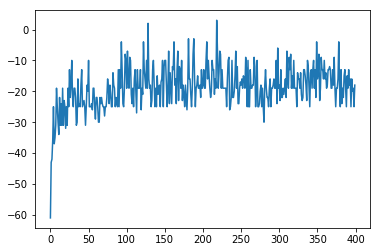

In [9]:
plt.plot(generational_fitness)
plt.show()